# MERFISH DE [GLUT]

In [25]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/trackfig')
from trackfig.utils import get_notebook_name
from trackfig.trackfig import trackfig 

TRACKFIG = "/home/sina/projects/mop/BYVSTZP_2020/trackfig.txt"
NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [3]:
gene = anndata.read_h5ad("../../data/notebook/revision/merfish-updated.h5ad")

In [4]:
gene

AnnData object with n_obs × n_vars = 280327 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'cell_id'
    var: 'n_iso'
    layers: 'X', 'log1p', 'norm'

In [5]:
gene = gene[:,gene.var.sort_index().index]

In [6]:
print(gene.shape)

(280327, 254)


In [10]:
gene = gene[gene.obs.class_label=="Glutamatergic"]

# DE on genes

In [16]:
%%time
mat           = gene.layers["log1p"].todense()
components    = gene.obs.cell_id.values
features      = gene.var.index.values
assignments   = gene.obs.subclass.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_raw = p_raw/2
p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
markers_gene = markers_gene.query("es > 0")

18-Nov-20 17:03:20 - 1 of 9 assignments: L23_IT
18-Nov-20 17:03:22 - 2 of 9 assignments: L45_IT
18-Nov-20 17:03:23 - 3 of 9 assignments: L56_NP
18-Nov-20 17:03:24 - 4 of 9 assignments: L5_IT
18-Nov-20 17:03:26 - 5 of 9 assignments: L5_PT
18-Nov-20 17:03:27 - 6 of 9 assignments: L6_CT
18-Nov-20 17:03:28 - 7 of 9 assignments: L6_IT
18-Nov-20 17:03:30 - 8 of 9 assignments: L6_IT_Car3
18-Nov-20 17:03:31 - 9 of 9 assignments: L6b


CPU times: user 10.1 s, sys: 5.41 s, total: 15.5 s
Wall time: 15.5 s


# Look at the genes

In [17]:
alpha = 0.01
markers_gene.query(f"p_corr < {alpha}").sort_values("es").tail()

,index,name,p_raw,p_corr,es
1359,L6_CT,Foxp2,0,2.22507e-308,8.47911
1493,L6_CT,Syt6,0,2.22507e-308,9.13136
1921,L6_IT_Car3,Nr4a2,0,2.22507e-308,9.38158
2179,L6b,Nxph4,0,2.22507e-308,9.73656
2095,L6b,Cplx3,0,2.22507e-308,9.82794


In [18]:
specific_cluster = "L6_CT"
specific_gene = "Foxp2"

In [19]:
specific_gene

'Foxp2'

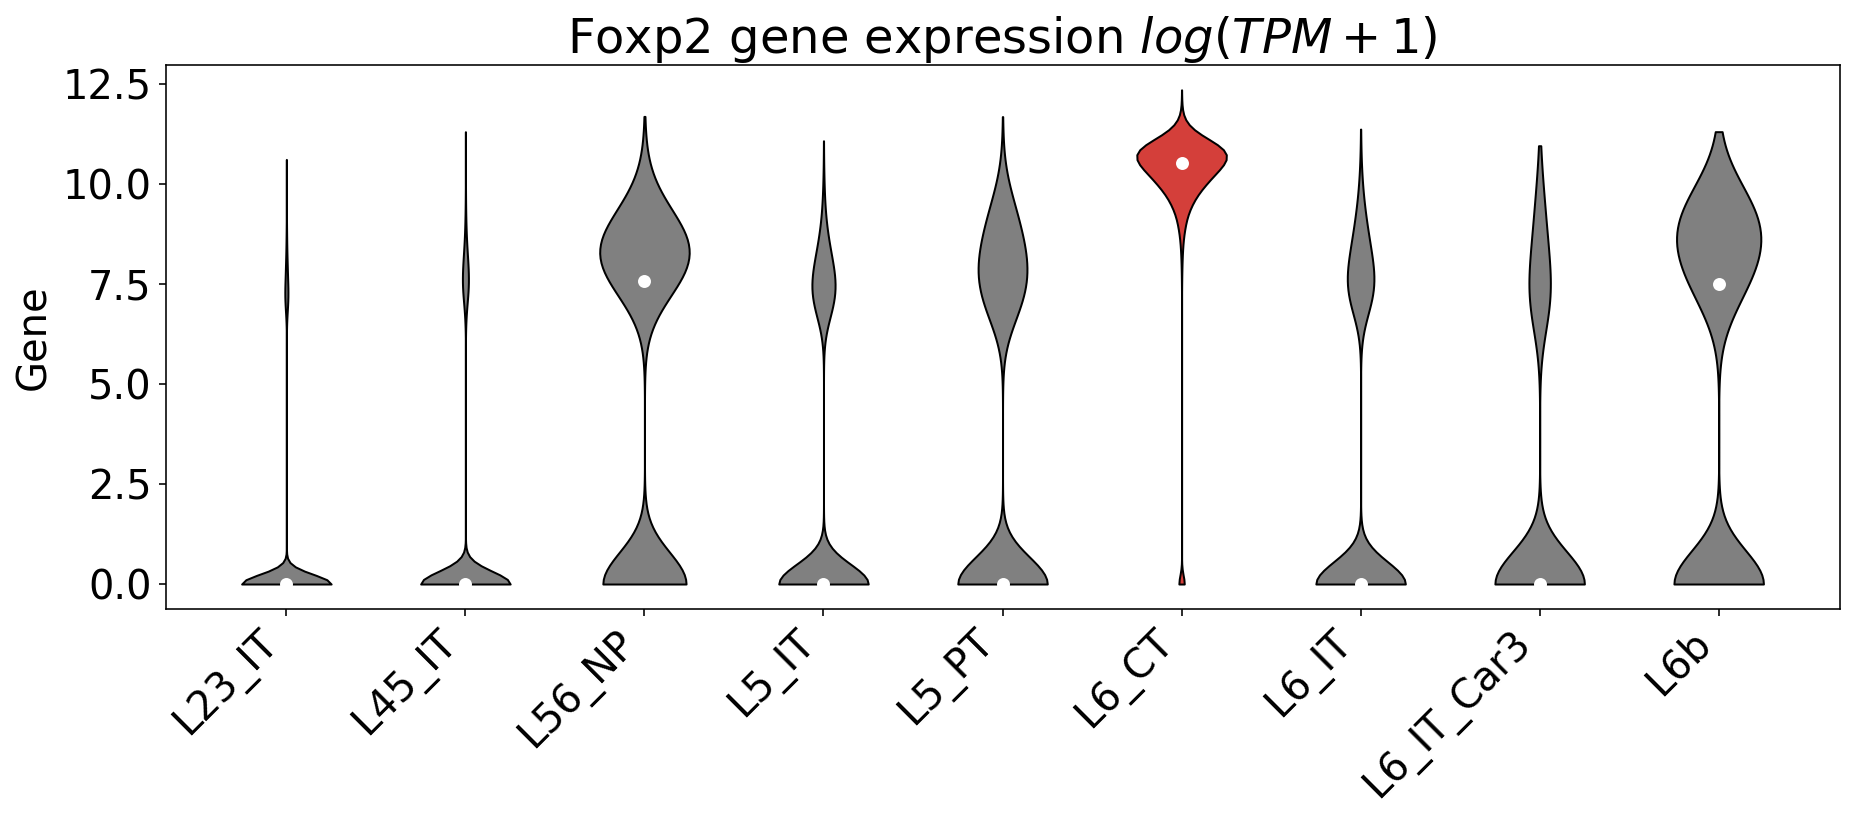

In [21]:
fig, ax = plt.subplots(figsize=(15,5))
fig.subplots_adjust(hspace=0, wspace=0)

unique = np.unique(gene.obs.subclass)


labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
#######3# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.subclass==c][:,gene.var.index.values==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

parts = ax.violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor("#D43F3A")

medians = [np.median(i) for i in x]
ax.scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)

#ax[0].axhline(y=medians[midx], color="k", linestyle="--")
ax.set_ylabel("Gene")


medians = [np.median(i) for i in x]
ax.set_xticks(lidx)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_title("{} gene expression $log(TPM + 1)$".format(specific_gene))
plt.savefig(trackfig("../../figures/merfish-updated_subclass_DE_violin_{}-GLUT.png".format(specific_gene.split("_")[0]), TRACKFIG, NB), bbox_inches='tight',dpi=300)
plt.show()

In [22]:
identified_genes = markers_gene["name"].explode().astype(str)
identified_genes = identified_genes[identified_genes!="nan"]

In [23]:
print("{} genes identified.".format(identified_genes.nunique()))

64 genes identified.


In [24]:
markers_gene.to_csv(trackfig("../../tables/unordered/merfish-updated_DE-GLUT.csv", TRACKFIG, NB))